# Twitter disaster response messages

## 1. Introduction

The dataset is made available by [Figure Eight](https://www.figure-eight.com) and it comprises a set of messages related to disaster response, covering multiple languages, suitable for text categorization and related natural language processing tasks.

The messages are translated to english and classified.


### 1.1 Goal

The goal is to train a classifier able to detect different emergencies or disaster situations.

We compare approached based on word frequency (TFIDF) with approached based on word embeddings and neural networks (through SpaCy).


In [23]:
import numpy as np
import pandas as pd
import pylab as plt

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.util import minibatch, compounding

import re
import urllib.request
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

nlp = spacy.load("en_core_web_md")

In [122]:
from sklearn.base import TransformerMixin


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix

import sklearn.metrics as met

from scipy.stats import randint as sp_randint , uniform


In [2]:
# download data files

if 0:
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_training.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_training.csv')
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_test.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_test.csv')
    url = 'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_validation.csv'  
    urllib.request.urlretrieve(url, 'disaster_response_messages_validation.csv')
    
    

In [3]:
df=pd.read_csv('disaster_response_messages_training.csv')
df=df.drop(columns=['original','split'])

C:\anaconda3\envs\ds\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [298]:
df.iloc[:,:10].head()

,id,message,genre,related,PII,request,offer,aid_related,medical_help,medical_products
0,2,Weather update - a cold front from Cuba that could pass over Haiti,direct,1,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,direct,1,0,0,0,1,0,0
2,12,"says: west side of Haiti, rest of the country today and tonight",direct,1,0,0,0,0,0,0
3,14,Information about the National Palace-,direct,0,0,0,0,0,0,0
4,15,Storm at sacred heart of jesus,direct,1,0,0,0,0,0,0


number of messages:  21046


Text(0,0.5,'percentage positve')

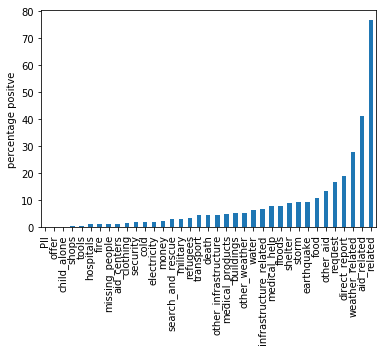

In [24]:
n_messages=df.shape[0]
print("number of messages: ",n_messages)

perc_positive=100.*df.iloc[:,3:].sum()/n_messages
perc_positive=perc_positive.sort_values()
perc_positive.plot(kind='bar');
plt.ylabel('percentage positve')


In [307]:
display(df['message'].to_frame().head(10))

,message
0,Weather update - a cold front from Cuba that could pass over Haiti
1,Is the Hurricane over or is it not over
2,"says: west side of Haiti, rest of the country today and tonight"
3,Information about the National Palace-
4,Storm at sacred heart of jesus
5,"Please, we need tents and water. We are in Silo, Thank you!"
6,"I would like to receive the messages, thank you"
7,"There's nothing to eat and water, we starving and thirsty."
8,I am in Petionville. I need more information regarding 4636
9,"I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks"


## 2 Preprocessing

The CountVectorizer tool is used to extract the most relevant (typically the most frequently used) words in a corpus of text documnents.

If used naively, we observe that:
* commond words with little predicted value (and, like, be, but ...) are included.
* names of countries, cities and nationalities may also included

In [58]:
bow = CountVectorizer(max_features=1000,)
bow.fit(df.loc[0:1000,'message'])
print(bow.get_feature_names()[0:100])


['10', '11', '12', '12th', '15', '150', '16', '18', '19', '20', '200', '2000', '2010', '22', '23', '24', '27', '29', '30', '31', '32', '33', '35', '37', '3rd', '40', '41', '42', '43', '4636', '48', '4th', '50', '500', '52', '54', '600', '75', '79', '87', 'able', 'about', 'abroad', 'academy', 'access', 'account', 'across', 'action', 'actually', 'address', 'adopt', 'adress', 'advance', 'advertising', 'advise', 'after', 'afternoon', 'aftershake', 'aftershock', 'aftershocks', 'again', 'aid', 'aide', 'aids', 'airport', 'airtime', 'alerte', 'alexandre', 'alive', 'all', 'almost', 'alone', 'along', 'alot', 'already', 'also', 'always', 'am', 'ambroise', 'american', 'americans', 'an', 'and', 'another', 'anse', 'answer', 'antoine', 'any', 'anymore', 'anyone', 'anything', 'aquin', 'are', 'area', 'areas', 'aren', 'army', 'around', 'arrived', 'artibonit']


To prevent such issues we use a more sophisticated tokenizer (based on SpaCy) that can:
* remove common English stop words
* remove Named Entities such as countries, cities, organizations etc

In [196]:
def spacy_tokenizer(message):
    message=re.sub("[#@$'!*+%\".()!,]?;",'',message).replace('','').replace('-','')
    message=' '.join(message.split())
    doc=nlp(message)
    words=[]

    remove_ent=[]
    for ent in doc.ents:
        if ent.label_ in ['GPE','LOC','NORP','FAC','ORG','LANGUAGE']:
            remove_ent.append(ent.text)

    # remove punctuation etc
    for token in doc:
        if ( (~token.is_stop)   & (token.pos_!='NUM') & (token.pos_!='PUNCT') & (token.pos_!='SYM') &
           ~(token.text in (remove_ent)) & (len(token.text)>1) ):
            words.append(token.text)
    return(words)



It is highly recommended to check the words choose by the algorithm:
* for a small subset of messages to catch obvious issues (too many numbers, ...)
* on the positive disaster messages on a few classes to see if obvious trigger words are identified

In [308]:
bow = CountVectorizer(tokenizer = spacy_tokenizer, max_df=0.9,min_df=2, max_features=500)
bow.fit(df.loc[0:500,'message'])
# bow.fit(df.loc[df.food==1,'message'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=500, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x000000001CEB1048>,
                vocabulary=None)

In [310]:
print(bow.get_feature_names()[0:50])

['..', '...', '10', '12', '12th', '15', '16', '2000', '24', '27', '29', '30', '31', '32', '33', '35', '3rd', '41', '43', '4636', '50', '500', '75', 'abroad', 'action', 'address', 'adress', 'advertising', 'afternoon', 'aid', 'airport', 'alive', 'alot', 'american', 'antoine', 'anymore', 'apparently', 'area', 'areas', 'arrived', 'artists', 'ask', 'asking', 'assistance', 'association', 'au', 'authorities', 'available', 'avenue', 'b.']


## 3. Term frequency approach

We test a simple approach based on term frequency and standard classifiers.

In [98]:
X_train, X_test, Y_train, Y_test = train_test_split(df['message'], df['food'], test_size=0.2)

In [99]:
bow = CountVectorizer(tokenizer = spacy_tokenizer, max_df=0.9,min_df=2, max_features=10000)
bow.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.9, max_features=10000, min_df=2,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x000000001446DBF8>,
                vocabulary=None)

In [100]:
X_train_cv = bow.transform(X_train)
tfidf = TfidfTransformer()
tfidf.fit(X_train_cv)
X_train_tdidf = tfidf.transform(X_train_cv)


In [110]:
X_test_cv = bow.transform(X_test)
X_test_tdidf = tfidf.transform(X_test_cv)

### 3.1 LogisticRegression Classifier

In [129]:

model = Pipeline([
        ('clf', LogisticRegression(random_state=0, solver='liblinear',penalty='l1',max_iter=200,class_weight='balanced',
                                   )  ),
    ])
parameters = {
    'clf__C': uniform(.001, 1),
}

cv_folds = 5

scorerAP = make_scorer(met.average_precision_score, greater_is_better=True)
cv = RandomizedSearchCV(model, scoring=scorerAP, param_distributions=parameters, verbose=1, cv=cv_folds, refit='AP')

cv.fit(X_train_tdidf,Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.1s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('clf',
                                              LogisticRegression(C=1.0,
                                                                 class_weight='balanced',
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_iter=200,
                                                                 multi_class='warn',
                                                                 n_jobs=None,
                                                                 penalty='l1',
                           

In [130]:
clf=cv.best_estimator_
y_pred=clf.predict(X_test_tdidf)


In [312]:
print(classification_report(Y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3732
           1       0.81      0.75      0.78       478

    accuracy                           0.95      4210
   macro avg       0.89      0.87      0.88      4210
weighted avg       0.95      0.95      0.95      4210



In [318]:
display(pd.DataFrame( confusion_matrix(Y_test,y_pred),columns=['y_pred 0','y_pred 1'],index=['y_true 0','y_true 1'] ) )

,y_pred 0,y_pred 1
y_true 0,3648,84
y_true 1,118,360


### 3.2 Random Forest Classifier

In [133]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": sp_randint(1, 20),
              "max_features": sp_randint(1, 40),
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 30
clf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
cv = RandomizedSearchCV(clf,scoring='average_precision', param_distributions=param_dist,  cv=5, iid=False,  n_iter=n_iter_search)

cv.fit(X_train_tdidf,Y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=20,
                                                    class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jo

In [134]:
clf=cv.best_estimator_
y_pred=clf.predict(X_test_tdidf)

In [135]:
print(classification_report(Y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3732
           1       0.48      0.67      0.56       478

    accuracy                           0.88      4210
   macro avg       0.72      0.79      0.75      4210
weighted avg       0.90      0.88      0.89      4210



In [136]:
print(confusion_matrix(Y_test,y_pred))

[[3392  340]
 [ 158  320]]


##  3.3 Gradient Boosted Decision Trees

In [148]:
import xgboost as xgb
from xgboost import XGBClassifier

params = {  
    "n_estimators": sp_randint(3, 40),
    "max_depth": sp_randint(3, 40),
    "learning_rate": uniform(0.05, 0.4),
    "gamma": uniform(0, 10),
}
# run randomized search
n_iter_search = 10
clf = XGBClassifier()
cv = RandomizedSearchCV(clf,scoring='average_precision', param_distributions=param_dist,  cv=5, iid=False,  n_iter=n_iter_search)

cv.fit(X_train_tdidf,Y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000001CE64668>,
                                        'min_samples_split': <scipy.stats._distn_infrastr

In [149]:
y_pred=model.predict(X_test_tdidf)

In [155]:
print(classification_report(Y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3732
           1       0.81      0.75      0.78       478

    accuracy                           0.95      4210
   macro avg       0.89      0.87      0.88      4210
weighted avg       0.95      0.95      0.95      4210



In [156]:
print(confusion_matrix(Y_test,y_pred))

[[3648   84]
 [ 118  360]]


### 3.4 Conclusion

## 4. Word embedding approach

### 4.1 Example of word embeddings

In [243]:
food_message1= df.loc[df.food==1,'message'].iloc[0] 
food_message2= df.loc[df.food==1,'message'].iloc[5] 
other_message= df.loc[df.food==0,'message'].iloc[6] 
print("message1: ",food_message1)
print("message2: ",food_message2)
print()
print("message3: ",other_message)

t1=nlp(food_message1)
t2=nlp(food_message2)
t3=nlp(other_message)

print()
print()

print('message 1-2 similarity: ', t1.similarity(t2))
print('message 1-3 similarity: ', t1.similarity(t3))
print('message 2-3 similarity: ', t2.similarity(t3))




message1:  There's nothing to eat and water, we starving and thirsty.
message2:  How can we get water and food in Fontamara 43 cite Tinante?

message3:  I would like to receive the messages, thank you


message 1-2 similarity:  0.8998820194599932
message 1-3 similarity:  0.8150712829697143
message 2-3 similarity:  0.83254640420231


In [244]:
def embedding_tokenizer(message):
    message=re.sub("[#@$'!*+%\".()!,]?;",'',message).replace('','').replace('-','')
    message=' '.join(message.split())
    doc=nlp(message)
    words=[]

    remove_ent=[]
    for ent in doc.ents:
        if ent.label_ in ['GPE','LOC','NORP','FAC','ORG','LANGUAGE']:
            remove_ent.append(ent.text)

    # remove punctuation etc
    for token in doc:
        if ( (~token.is_stop)   & (token.pos_!='NUM') & (token.pos_!='PUNCT') & (token.pos_!='SYM') &
           ~(token.text in (remove_ent)) & (len(token.text)>1) & (token.has_vector) ):
            words.append(token.text)
    return(words)

In [245]:
t1=nlp(" ".join(embedding_tokenizer(food_message1)))
t2=nlp(" ".join(embedding_tokenizer(food_message2)))
t3=nlp(" ".join(embedding_tokenizer(other_message)))

print(t1)
print(t2)
print(t3)

print( )

print('message 1-2 similarity: ', t1.similarity(t2))
print('message 1-3 similarity: ', t1.similarity(t3))
print('message 2-3 similarity: ', t2.similarity(t3))


eat water starving thirsty
water food cite
like receive messages thank

message 1-2 similarity:  0.7056666438629938
message 1-3 similarity:  0.35251518688406175
message 2-3 similarity:  0.37734246809506683


In [253]:
train =pd.concat((X_train,Y_train),axis=1).values

In [269]:
train[1]

array(['Weeks passed without any aid coming to this village, while helicopters flew overhead, ferrying supplies elsewhere.',
       0], dtype=object)

In [277]:
def load_data(train_data,limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation

    random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

In [273]:
if "textcat" not in nlp.pipe_names:
    textcat = nlp.create_pipe(
        "textcat",
        config={
            "exclusive_classes": True,
            "architecture": "simple_cnn",
        }
    )
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe("textcat")
    

In [274]:
# nlp.remove_pipe("textcat")

In [276]:
textcat.add_label('POSITIVE')
textcat.add_label("NEGATIVE")

1

In [278]:
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(train)

In [287]:
n_texts=1000

train_texts = train_texts[:n_texts]
train_cats = train_cats[:n_texts]

print(
        "Using {} examples ({} training, {} evaluation)".format(
            n_texts, len(train_texts), len(dev_texts)
        )
    )

Using 1000 examples (1000 training, 3368 evaluation)


In [286]:
train_texts[0], train_cats[0]

('Communication minister Issa Tchiroma Bakary did not elaborate on the nationality of the foreigners, who were among the more than 100 killed during an attempted cross-border raid at the weekend.',
 {'POSITIVE': False, 'NEGATIVE': True})

In [294]:
def evaluate(tokenizer, textcat, texts, cats):
    
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


In [290]:
train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]



In [295]:
init_tok2vec=None

n_iter=20

with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
    batch_sizes = compounding(4.0, 32.0, 1.001)
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        random.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print(
            "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                losses["textcat"],
                scores["textcat_p"],
                scores["textcat_r"],
                scores["textcat_f"],
            )
        )


Training the model...
LOSS 	  P  	  R  	  F  
0.910	0.730	0.293	0.419
0.150	0.626	0.276	0.383
0.009	0.618	0.268	0.374
0.000	0.661	0.211	0.320
0.000	0.679	0.205	0.315
0.000	0.680	0.199	0.308
0.000	0.680	0.199	0.308
0.000	0.683	0.197	0.305
0.000	0.686	0.199	0.309
0.000	0.661	0.205	0.313
0.000	0.655	0.205	0.312
0.000	0.661	0.205	0.313
0.000	0.661	0.205	0.313
0.000	0.661	0.205	0.313
0.000	0.661	0.205	0.313
0.000	0.667	0.205	0.314
0.000	0.667	0.205	0.314
0.000	0.667	0.205	0.314
0.000	0.667	0.205	0.314
0.000	0.673	0.205	0.314


In [296]:
# test the trained model
test_text = "We are starving and we need urgently food: water, bread, milk"
doc = nlp(test_text)
print(test_text, doc.cats)

# if output_dir is not None:
#     with nlp.use_params(optimizer.averages):
#         nlp.to_disk(output_dir)
#     print("Saved model to", output_dir)

#     # test the saved model
#     print("Loading from", output_dir)
#     nlp2 = spacy.load(output_dir)
#     doc2 = nlp2(test_text)
#     print(test_text, doc2.cats)


We are starving and we need urgently food: water, bread, milk {'POSITIVE': 0.8373962044715881, 'NEGATIVE': 0.16260382533073425}
